In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter('error')
import sys
sys.path.append('/DATA/publish/mocet/analysis')
import mocet
from utils.base import get_minecraft_subjects, get_project_directory, get_mm_px_scaling, get_configs
subject_pool = get_minecraft_subjects()
project_dir = get_project_directory()
scaling_mm_per_px = get_mm_px_scaling()
configs = get_configs()

from matplotlib.gridspec import GridSpec

# Parameters for Minecraft task

calibration_onsets = configs['calibration_onsets']
calibration_points = configs['calibration_points']
interval = configs['interval']
task_duration = configs['task_duration']
task = configs['task']

calibration_offset_start = configs['calibration_offset_start']
calibration_offset_end = configs['calibration_offset_end']
calibration_threshold = configs['calibration_threshold']
px_per_deg = configs['px_per_deg']
avg_pupil_diameter_mm = configs['avg_pupil_diameter_mm']
calibration_coordinates = configs['calibration_coordinates']
calibration_order = configs['calibration_order']

Average palpebral fissure height in mm: 10.73076923076923 ± 1.309952797378954


In [4]:
group_subjects = []
group_calibration_errors = []
group_validation_errors = []
valid_data = {}
usable_data = {}
unusable_data = {}

subjects = list(subject_pool.keys())
for subject in subjects:
    subject_calibration_errors = []
    subject_validation_errors = []

    sessions = subject_pool[subject].keys()
    for session in sessions:
        runs = subject_pool[subject][session]
        root = f'{project_dir}/data/eyetracking/{subject}/{session}'
        for r in runs:
            np.random.seed(0) # for reproducibility

            run = f'run-{r}'
            log_fname = f'{root}/{subject}_{session}_{task}_{run}_recording-eyetracking_physio_log.csv'
            data_fname = f'{root}/{subject}_{session}_{task}_{run}_recording-eyetracking_physio_dat.txt'
            confounds_fname = f'{root}/{subject}_{session}_{task}_{run}_desc-confounds_timeseries.tsv'
            history_fname = f'{root}/{subject}_{session}_{task}_{run}_recording-eyetracking_physio_his.txt'
            start, _, _ = mocet.utils.get_viewpoint_history(history_fname)

            # log, data, confound, start
            pupil_data, pupil_timestamps, pupil_confidence, pupil_diameter = mocet.utils.clean_viewpoint_data(log_fname,
                                                                                                    data_fname,
                                                                                                    start=start,
                                                                                                    duration=task_duration)
            pupil_validity = np.sum(np.isnan(pupil_confidence))/len(pupil_confidence)
            mean_pupil_confidence = np.nanmean(pupil_confidence)
            mean_pupil_diameter = np.nanmean(pupil_diameter)
            #pupil_diameter_mm_per_px = avg_pupil_diameter_mm / mean_pupil_diameter
            mm_per_px = scaling_mm_per_px[(subject, session)]

            if pupil_timestamps[-1] > ((task_duration-1))*1000: # if the eye tracking data have enough length
                calibration_errors = []
                calibration_n_valid_points = []
                for t in range(len(calibration_points)):
                    offset = calibration_onsets[t]
                    calibration_pupils = []
                    for i in np.arange(calibration_points[t]):
                        start = (offset+i)*interval + calibration_offset_start
                        end = (offset+i+1)*interval + calibration_offset_end
                        log_effective = np.logical_and(pupil_timestamps >= start*1000, pupil_timestamps < end*1000)
                        if np.sum(log_effective) > 0:
                            calibration_pupils.append([np.nanmean(pupil_data[log_effective,0]),
                                                      np.nanmean(pupil_data[log_effective,1])])
                        else:
                            calibration_pupils.append(calibration_pupils[-1]) # it does not allow calibration
                    calibration_pupils = np.array(calibration_pupils)

                    repeat = True if calibration_points[t]==24 else False
                    calibrator = mocet.EyetrackingCalibration(calibration_coordinates = calibration_coordinates,
                                                              calibration_order = calibration_order,
                                                              repeat=repeat)
                    calibrated = calibrator.fit(calibration_pupils[:, 0], calibration_pupils[:, 1])
                    if calibrated:
                        gaze_coordinates = calibrator.transform(pupil_data)

                        # Test accuracy
                        MSE = []
                        calibration_confidence = []
                        for i in np.arange(calibration_points[t]):
                            ref_x, ref_y = calibrator.reference(i)
                            start = (offset+i)*interval + calibration_offset_start
                            end = (offset+i+1)*interval + calibration_offset_end
                            gaze_idx_start = np.min(np.where(pupil_timestamps >= start*1000)[0])
                            gaze_idx_end = np.min(np.where(pupil_timestamps >= end*1000)[0])
                            eye_closed = np.isnan(pupil_confidence[gaze_idx_start:gaze_idx_end])
                            calibration_confidence += list(pupil_confidence[gaze_idx_start:gaze_idx_end])
                            if np.any(~eye_closed):
                                data_x = np.nanmean(gaze_coordinates[gaze_idx_start:gaze_idx_end,0][~eye_closed])
                                data_y = np.nanmean(gaze_coordinates[gaze_idx_start:gaze_idx_end,1][~eye_closed])
                                MSE.append(np.sqrt((ref_x-data_x)**2 + (ref_y-data_y)**2))

                        if len(MSE) >= 12:
                            #mean_calibration_confidence = np.nanmean(calibration_confidence)
                            calibration_errors.append(np.nanmean(MSE)/px_per_deg)
                            calibration_n_valid_points.append(len(MSE))
                        else:
                            calibration_errors.append(10e5)
                            calibration_n_valid_points.append(0)
                    else:
                        calibration_errors.append(10e5)
                        calibration_n_valid_points.append(0)
                print('---------------------------------------------')
                print(subject, session, task, run)
                print(f"Eye closed: {pupil_validity:2.2f}, Avg. confidence: {mean_pupil_confidence:2.2f}, Avg. diameter: {mean_pupil_diameter:2.2f}")

                t_cal, t_val = 0, 1
                key = (subject, session, task, run)
                if calibration_errors[t_cal] < calibration_threshold and calibration_errors[t_val] < calibration_threshold:
                    calibration_pupils = []
                    offset = calibration_onsets[t_cal]
                    for i in np.arange(calibration_points[t_cal]):
                        start = (offset+i)*interval + calibration_offset_start
                        end = (offset+i+1)*interval + calibration_offset_end
                        log_effective = np.logical_and(pupil_timestamps >= start*1000, pupil_timestamps < end*1000)
                        calibration_pupils.append([np.nanmean(pupil_data[log_effective,0]),
                                                  np.nanmean(pupil_data[log_effective,1])])
                    calibration_pupils = np.array(calibration_pupils)
                    calibration_center = np.mean(calibration_pupils, axis=0)

                    repeat = True if calibration_points[t_cal]==24 else False
                    calibrator = mocet.EyetrackingCalibration(calibration_coordinates = calibration_coordinates,
                                                              calibration_order = calibration_order,
                                                              repeat=repeat)
                    calibrator.fit(calibration_pupils[:, 0], calibration_pupils[:, 1])
                    gaze_coordinates = calibrator.transform(pupil_data)


                    MSE = []
                    offset = calibration_onsets[t_val]
                    validation_pupils = []
                    for i in np.arange(calibration_points[t_val]):
                        ref_x, ref_y = calibrator.reference(i)
                        start = (offset+i)*interval + calibration_offset_start
                        end = (offset+i+1)*interval + calibration_offset_end
                        log_effective = np.logical_and(pupil_timestamps >= start*1000, pupil_timestamps < end*1000)
                        validation_pupils.append([np.nanmean(pupil_data[log_effective,0]),
                                                  np.nanmean(pupil_data[log_effective,1])])

                        gaze_idx_start = np.min(np.where(pupil_timestamps >= start*1000)[0])
                        gaze_idx_end = np.min(np.where(pupil_timestamps >= end*1000)[0])
                        eye_closed = np.isnan(pupil_confidence[gaze_idx_start:gaze_idx_end])
                        if np.any(~eye_closed):
                            data_x = np.nanmean(gaze_coordinates[gaze_idx_start:gaze_idx_end,0][~eye_closed])
                            data_y = np.nanmean(gaze_coordinates[gaze_idx_start:gaze_idx_end,1][~eye_closed])
                            MSE.append(np.sqrt((ref_x-data_x)**2 + (ref_y-data_y)**2))
                    if len(MSE) > 0:
                        validation_error = np.nanmean(MSE)/px_per_deg
                        validation_center = np.mean(validation_pupils, axis=0)
                    else:
                        validation_error = np.nan
                        validation_center = np.nan * np.ones(2)
                    calibration_error = calibration_errors[t_cal]

                    subject_calibration_errors.append(calibration_error)
                    subject_validation_errors.append(validation_error)
                    pupil_displacement = np.linalg.norm(calibration_center - validation_center) * mm_per_px
                    pupil_displacement_x = (calibration_center[0] - validation_center[0]) * mm_per_px
                    pupil_displacement_y = (calibration_center[1] - validation_center[1]) * mm_per_px
                    valid_data[key] = (calibration_errors[t_cal],
                                       calibration_errors[t_val],
                                       validation_error,
                                       pupil_displacement,
                                       pupil_displacement_x,
                                       pupil_displacement_y)
                    usable_data[key] = (calibration_errors[t_cal], calibration_errors[t_val])
                    print(f"Calibration error: {calibration_error:3.3f} deg, Validation error: {validation_error:3.3f} deg")

                elif calibration_errors[t_cal] < calibration_threshold:
                    usable_data[key] = (calibration_errors[t_cal], calibration_errors[t_val])
                    print(f"This data is unreliable but still usable. Calibration error: {calibration_errors[t_cal]:3.3f} deg")
                else:
                    unusable_data[key] = (calibration_errors[t_cal], calibration_errors[t_val])
                    print(f"This data is unusable. Calibration error: {calibration_errors[t_cal]:3.3f} deg")
            else:
                key = (subject, session, task, run)
                unusable_data[key] = (None, None)
                print('---------------------------------------------')
                print(subject, session, task, run)
                print(f"This data is broken!")

    if len(subject_calibration_errors)>0 and len(subject_validation_errors)>0:
        group_subjects.append(subject)
        group_calibration_errors.append(np.nanmean(subject_calibration_errors))
        group_validation_errors.append(np.nanmean(subject_validation_errors))

print(np.mean(group_calibration_errors), np.mean(group_validation_errors))

---------------------------------------------
sub-003 ses-07R task-mcHERDING run-1
Eye closed: 0.07, Avg. confidence: 0.99, Avg. diameter: 91.91
Calibration error: 0.442 deg, Validation error: 11.692 deg
---------------------------------------------
sub-003 ses-07R task-mcHERDING run-2
Eye closed: 0.10, Avg. confidence: 0.99, Avg. diameter: 96.15
Calibration error: 0.405 deg, Validation error: 14.465 deg
---------------------------------------------
sub-003 ses-07R task-mcHERDING run-3
Eye closed: 0.07, Avg. confidence: 0.99, Avg. diameter: 95.50
Calibration error: 0.438 deg, Validation error: 6.007 deg
---------------------------------------------
sub-003 ses-07R task-mcHERDING run-4
Eye closed: 0.08, Avg. confidence: 0.99, Avg. diameter: 92.76
This data is unreliable but still usable. Calibration error: 0.274 deg
---------------------------------------------
sub-003 ses-07R task-mcHERDING run-5
This data is broken!
---------------------------------------------
sub-003 ses-13R task-mc

In [5]:
save_data = True
if save_data:
    import pickle
    with open('../data/valid_data_list.pkl', 'wb') as f:
        pickle.dump(valid_data, f)
    with open('../data/usable_data_list.pkl', 'wb') as f:
        pickle.dump(usable_data, f)
    with open('../data/unusable_data_list.pkl', 'wb') as f:
        pickle.dump(unusable_data, f)

In [4]:
def merge_dicts(x, y):
    z = x.copy()
    z.update(y)
    return z

all_data = merge_dicts(usable_data, unusable_data)
with open('../data/all_data_list.pkl', 'wb') as f:
    pickle.dump(all_data, f)

In [5]:
print(len(valid_data), len(usable_data), len(usable_data)-len(valid_data), len(unusable_data))
usable_if_two_calibrations = 0
for value in unusable_data.values():
    if value[1] is not None:
        if np.any([value[0]<1.0, value[1]<1.0]):
            usable_if_two_calibrations += 1
print(len(unusable_data)-usable_if_two_calibrations, usable_if_two_calibrations)

133 178 45 38
27 11


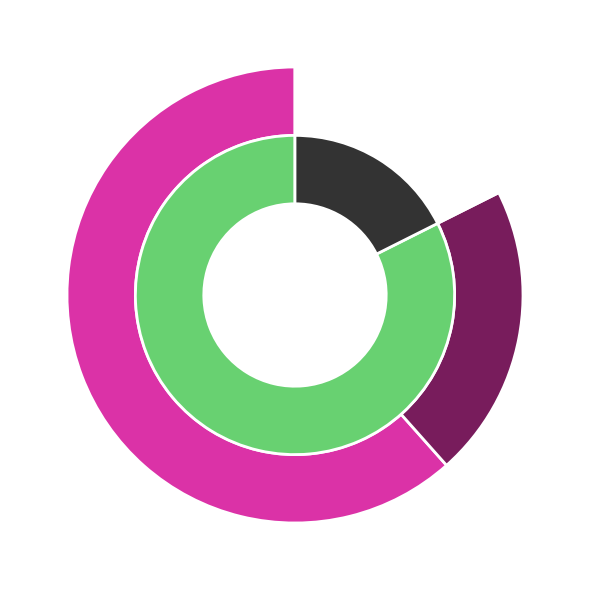

In [6]:
# Data
inner_labels = ['Usable', 'Unusable']
inner_sizes = [178, 38]  # example percentages
outer_labels = ['Verifiable', 'Unverifiable','Unusable', 'usable_if_two_calibrations']
outer_sizes = [133, 45, 38]  # must sum to inner 'Usable' size

# Create figure and axis
fig, ax = plt.subplots(figsize=(6, 6))

outer_colors = ['#db32a7', '#781c5c',  '#FFFFFF']
outer_wedges, _ = ax.pie(
    outer_sizes,
    radius=1.0,
    colors=outer_colors,
    startangle=90,
    wedgeprops=dict(width=0.3, edgecolor='w', linewidth=2)
)

inner_colors = ['#68d171', '#333333']
inner_wedges, _ = ax.pie(
    inner_sizes,
    radius=0.7,
    colors=inner_colors,
    startangle=90,
    wedgeprops=dict(width=0.3, edgecolor='w',linewidth=2)
)

# Inner white circle for donut effect in the center
centre_circle = plt.Circle((0, 0), 0.4, color='white', fc='white', linewidth=0)
ax.add_artist(centre_circle)

# Aspect ratio
ax.set(aspect="equal")
plt.tight_layout()
plt.show()

TtestResult(statistic=np.float64(-7.9477795161627665), pvalue=np.float64(3.989882614291593e-07), df=np.int64(17))


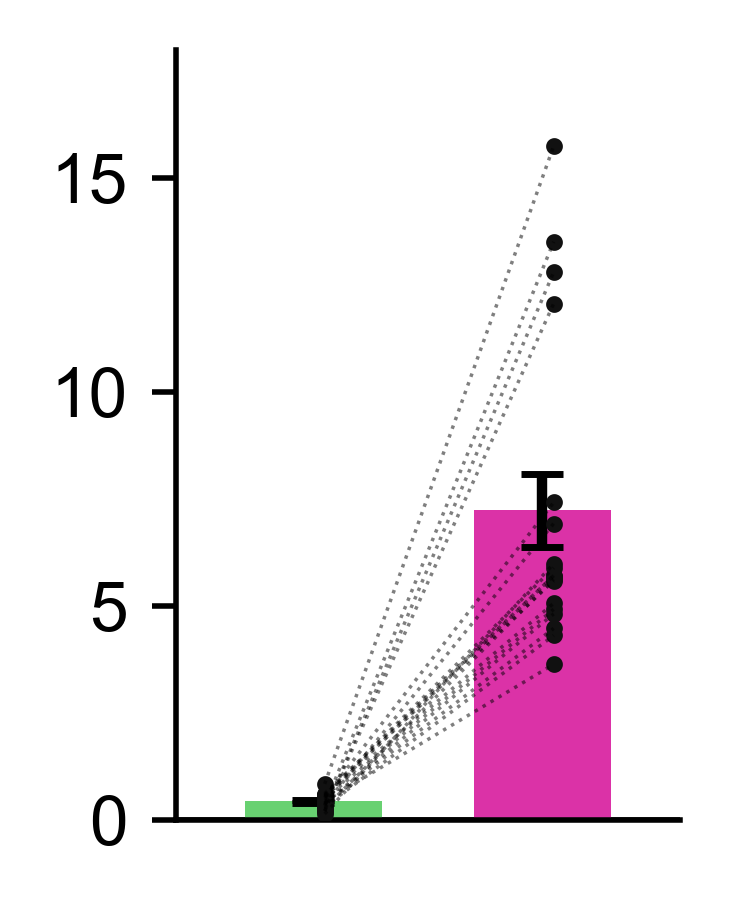

In [7]:
from scipy.stats import sem, ttest_rel, ttest_ind
print(ttest_rel(group_calibration_errors, group_validation_errors))

plt.style.use('default')
color_list = ['#68d171', '#db32a7']
fig, ax = plt.subplots(1,1,figsize=(1.3,2), dpi=500)

# for y in range(18):
#     if y % 5 == 0:
#         ax.axhline(y=y, color='k', linestyle='-', alpha=0.3, lw=0.3, zorder=0)
#     else:
#         ax.axhline(y=y, color='k', linestyle='-', alpha=0.1, lw=0.2, zorder=0)

ax.bar(np.arange(2),
       [np.mean(group_calibration_errors), np.mean(group_validation_errors)],
       yerr=[sem(group_calibration_errors), sem(group_validation_errors)],
       capsize=3, color=color_list, width=0.6, lw=0.5, zorder=10)

ax.scatter(0*np.ones(len(group_subjects))+0.05, group_calibration_errors, s=2, c='#111111', zorder=50)
ax.scatter(1*np.ones(len(group_subjects))+0.05, group_validation_errors, s=2, c='#111111', zorder=50)

for s in range(len(group_subjects)):
    ax.plot([0+0.05,1+0.05],
            [group_calibration_errors[s], group_validation_errors[s]],
            c='k', linestyle=':', lw=0.5, alpha=0.5, zorder=50)
ax.set_xlim(-0.6, 1.6)
ax.set_xticks([])
#ax.set_xticks([0,1])
#ax.set_xticklabels(['', ''])
ax.set_ylim(0.0, 18)
ax.set_yticks([0,5,10,15])
ax.axhline(0, c='k', lw=0.8, zorder=20)
ax.spines[['right', 'top']].set_visible(False)
for tick in ax.get_yticklabels():
    tick.set_fontname("Arial")
for tick in ax.get_xticklabels():
    tick.set_fontname("Arial")
plt.subplots_adjust(wspace=0.15)

In [6]:
# calibration_errors[t_cal],
#                                        calibration_errors[t_val],
#                                        validation_error,
#                                        pupil_displacement,
#                                        pupil_displacement_x,
#                                        pupil_displacement_y

data_name = []
calibation_errors = []
validation_errors = []
pupil_displacements = []
pupil_displacements_x = []
pupil_displacements_y = []
for data in valid_data.items():
    data_name.append(' '.join([data[0][0], data[0][1], data[0][3]]))
    calibation_errors.append(data[1][0])
    validation_errors.append(data[1][2])
    pupil_displacements.append(data[1][3])
    pupil_displacements_x.append(data[1][4])
    pupil_displacements_y.append(data[1][5])


PearsonRResult(statistic=np.float64(-0.15181575721068452), pvalue=np.float64(0.08108515522601761))
-3.9384110782893282 8.662506780286172


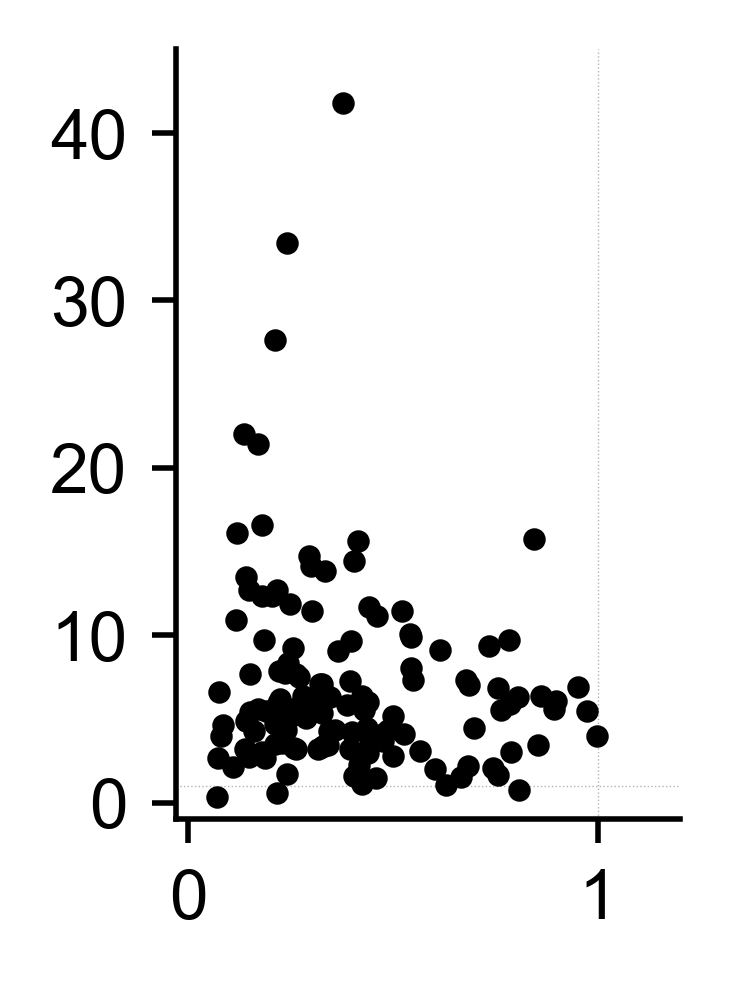

In [9]:


#c55187
from scipy.stats import linregress, pearsonr
x = np.array(calibation_errors)
y = np.array(validation_errors)
print(pearsonr(x,y))

slope, intercept, r, p, stderr = linregress(x, y)
print(slope, intercept)
x_range = np.linspace(np.min(x)-2, np.max(x)+5, 100)

fig, ax = plt.subplots(1,1,figsize=(1.3,2), dpi=500)

ax.axvline(x=1, color='k', linestyle=':', alpha=0.3, lw=0.2, zorder=0)
ax.axhline(y=1, color='k', linestyle=':', alpha=0.3, lw=0.2, zorder=0)

ax.scatter(x, y, s=5, c='k', zorder=100)
#ax.plot(x_range, slope*x_range + intercept, linestyle='--', c='k', lw=1, zorder=100)

ax.spines[['right', 'top']].set_visible(False)
ax.set_ylim(-1, 45)
ax.set_yticks([0,10,20,30,40])
ax.set_xlim(-0.03, 1.2)
ax.set_xticks([0,1])
for tick in ax.get_yticklabels():
    tick.set_fontname("Arial")
for tick in ax.get_xticklabels():
    tick.set_fontname("Arial")



PearsonRResult(statistic=np.float64(0.9694892698688664), pvalue=np.float64(7.371085961076478e-82))
4.447784121607846 0.7407150159351907


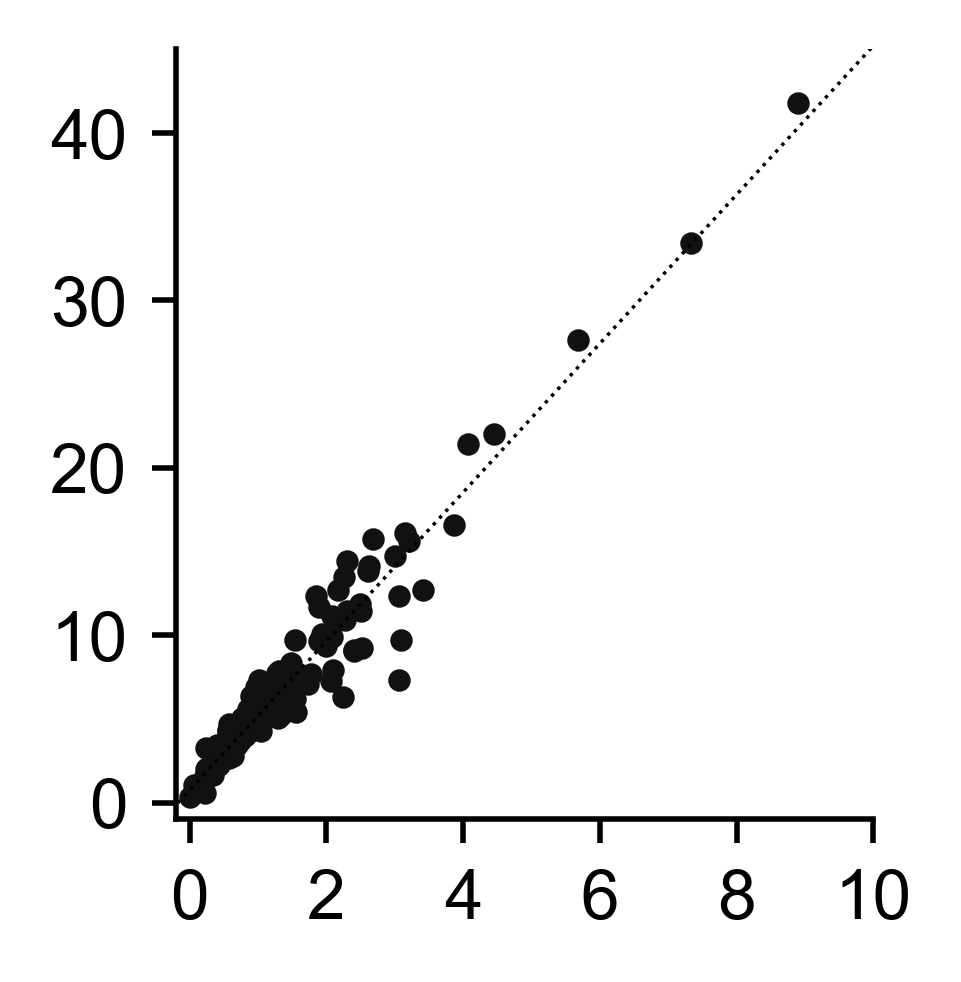

In [7]:
plt.style.use('default')


from scipy.stats import linregress, pearsonr
x = np.array(pupil_displacements)
y = np.array(validation_errors)
print(pearsonr(x,y))
slope, intercept, r, p, stderr = linregress(x, y)
#p = np.polyfit(np.log(x), y, 1)
# y = p[0] log(x) + p[1]
print(slope, intercept)
#print(p[0]*np.log(0.5) + p[1], p[0]*np.log(1.0) + p[1])
x_range = np.linspace(np.min(x)-2, np.max(x)+5, 100)

fig, ax = plt.subplots(1,1,figsize=(1.8,2), dpi=500)

# for yy in range(50):
#     if yy % 5 == 0:
#         ax.axhline(y=yy, color='k', linestyle='-', alpha=0.3, lw=0.3, zorder=0)
# for xx in range(20):
#     ax.axvline(x=xx, color='k', linestyle='-', alpha=0.1, lw=0.2, zorder=0)

ax.scatter(x, y, s=5, c='#111111', zorder=100)
ax.plot(x_range, slope*x_range + intercept, linestyle=':', c='k', lw=0.5, zorder=100)

ax.spines[['right', 'top']].set_visible(False)
ax.set_ylim(-1, 45)
ax.set_yticks([0,10,20,30,40])
ax.set_xlim(-0.2, 10)
ax.set_xticks([0,2, 4, 6,  8, 10])
for tick in ax.get_yticklabels():
    tick.set_fontname("Arial")
for tick in ax.get_xticklabels():
    tick.set_fontname("Arial")